In [29]:
! pip install matplotlib


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip install --upgrade pip


Import Python SDK.

In [30]:
import rby1_sdk

In [31]:
import time
import numpy as np

Connect the robot

In [32]:
robot = rby1_sdk.create_robot_a("0.0.0.0:50051")
robot.connect()

True

In [33]:
robot.power_on(".*") # Power On

True

In [34]:
robot.servo_on(".*") # Servo On

False

In [35]:
control_manager_state = robot.get_control_manager_state()
if control_manager_state.state == rby1_sdk.ControlManagerState.State.MinorFault or rby1_sdk.ControlManagerState.State.MajorFault:
    robot.reset_fault_control_manager()

In [36]:
robot.enable_control_manager() # Enable control manager

True

In [37]:
rc_position = []
rc_target_position = []
rc_target_feedforward = []

def cb(rs):
    global rc_position, rc_target_position, rc_target_feedforward
    rc_position = rc_position + [rs.position[3]]
    rc_target_position = rc_target_position + [rs.target_position[3]]
    rc_target_feedforward = rc_target_feedforward + [rs.target_feedforward_torque[3]]
    


robot.start_state_update(cb,
                         10  # (Hz)
                         )

In [38]:
time.sleep(0.5)

target_position = [0, 0.5, 0, 0, 0, 0] + [0, 0, 0, -1.2, 0, 0, 0] + [0, 0, 0, -1.2, 0, 0, 0]
rc = rby1_sdk.RobotCommandBuilder().set_command(
    rby1_sdk.ComponentBasedCommandBuilder()
    .set_body_command(
        rby1_sdk.BodyCommandBuilder(rby1_sdk.JointPositionCommandBuilder()
                                    .set_minimum_time(5)
                                    .set_acceleration_limit([3.] * 20)
                                    .set_position(target_position))
    )
)
robot.send_command(rc, 10).get()

time.sleep(2)

zero_position = np.array([0] * 20)
rc = rby1_sdk.RobotCommandBuilder().set_command(
    rby1_sdk.ComponentBasedCommandBuilder()
    .set_body_command(
        rby1_sdk.BodyCommandBuilder(rby1_sdk.JointPositionCommandBuilder()
                                    .set_minimum_time(5)
                                    .set_acceleration_limit([0.1] * 20)
                                    .set_position(zero_position))
    )
)
robot.send_command(rc, 10).get()

In [39]:
robot.stop_state_update()

In [40]:
from matplotlib import pyplot as plt

<Figure size 7200x3600 with 0 Axes>

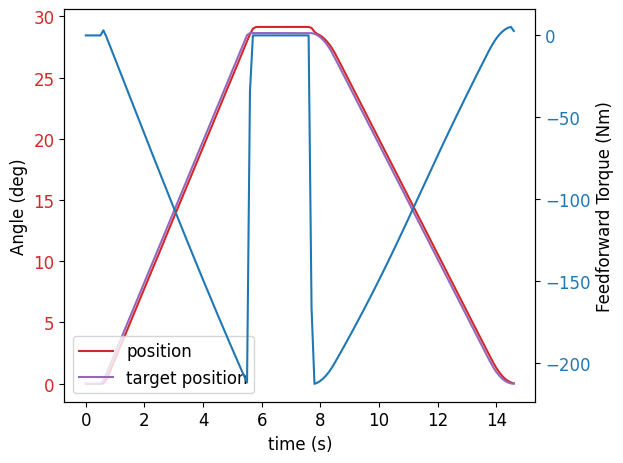

In [44]:
plt.figure(figsize=(12,6), facecolor='white', dpi=600)
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Angle (deg)')
ax1.plot(np.arange(0, len(rc_position)) * 0.1, np.transpose(np.rad2deg(np.array(rc_position))), label="position", color='tab:red')
ax1.plot(np.arange(0, len(rc_position)) * 0.1, np.transpose(np.rad2deg(np.array(rc_target_position))), label="target position", color='tab:purple')
ax1.legend(loc="lower left")
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Feedforward Torque (Nm)')
ax2.plot(np.arange(0, len(rc_position)) * 0.1, np.array(rc_target_feedforward), color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()